**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Constant Source, and Dirichlet BC

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Dr. Subash Sharma and Dr. Valmor de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**13 Dec 2024**

---
## Table of Contents<a id = "toc"></a>
* [Problem](#Problem)
  + [Objectives](#Obj)
  + [Data](#Data)
  + [Domain](#Domain) 
* [Test One](#test)
  + [Results](#Results)
  + [Comparing to Gold Solution](#Comparison)
  + [Comparing to Analytical Solution](#Analytical) 
* [Conclusion](#Conclusion) 
---

## [Problem](#toc)<a id = "Problem"></a>

Test One of the Thermal Modeling of the FIRES project focuses on solving a Poisson Model problem. We attempt to accomplish this analytically and numerically, within the context of heat conduction. The goals of this test are as followed: 

1) Find the temperature distrubution: Solve for the temperature profile across a 1-D domain within the given Dirichlet BC. Constant thermal conductivity and constant source.
2) Determine the heat flux: Calculating the derived quanitity, which represents the rate of heat flow through the material.
3) Set up the numerical minimization problem:
   * Approximate using a finite-dimensional space, with basic functions, which requires minimizing the Poisson energy norm.
   * Solve for the coefficents in the numerical approximation by solving the linear system. The matrices and load vector are definied using the basis functions.

By solving this problem analytically we are able to have a reference for validating results. A numerical calculation allows for the introduction of concepts relating a finite-dimensional approximation and energy minimization. 

### [Objective](#toc)<a id = "Data"><br> 

+ Find the temperature distribution *u*(*x*).
+ Determine the heat flux *q*(*x*)=-*ku'*(*x*)
+ Compare the analytical and numerical solutions
+ Compare the numerical solutions to a gold standard solution
+ Interpretation of *u*(*x*) and *q*(*x*)

### [Problem Data](#toc)<a id = "Data"></a>

> a = 0 cm <br>
> b = 5 cm <br>
> u(a) = 20 C <br>
> u(b) = 40 C <br>
> k = 42 W/(mK) <br>
> f = 824604 W/m^2 

### [Domain](#toc)<a id = "Domain"></a>

In [10]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0     # m
x_max = 0.05  # m

degree = 2  # Degree of the lagrange polinomials used
n_elem = 10 # Number of elements used

In [11]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

## [Implementing Data](#toc)<a id = "test"></a>

Test one constraints the system to a constant conductivity and constant source term with a Dirichlet boundary condition. The goal of simulating the domain under these conditions is to produce a graphical solution on how heat is transfered. 

In [14]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (42.0, 42.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (824604, 824604)) # W/m^3

view_plots = False

In [15]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [16]:
'''FEM Solution'''
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

In [17]:
'''Building the lift function'''
u_a = 20 #temperature at point a in degrees C
u_b = 40 #temperature at point b in degrees C

lift_func = linear_func(x_min, x_max, (u_a, u_b)) # C
lift_prime = (u_b-u_a)/(x_max-x_min)
lift_func_prime = linear_func(x_min, x_max, (lift_prime, lift_prime)) # C

view_plots = False

In [18]:
if view_plots:
    n_plot_pts = 200
    title = 'Lift Function'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'T [C]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Lift Function Prime'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'dT/dx [C/m]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [19]:
'''Build FEM A matrix'''
from pyfires import build_a_mtrx

a_mtrx = build_a_mtrx(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem)

In [20]:
'''Build load vector'''
from pyfires import build_b_vec

b_vec = build_b_vec(phi_list, phi_prime_list, k_func, f_func, lift_func_prime, domain_partition, x_min, x_max, n_elem)

### [Results](#toc)<a id = "Results"></a>

In [22]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

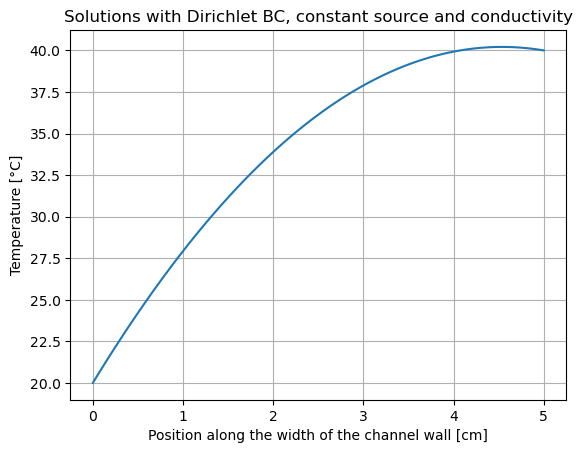

In [23]:
from pyfires import u_star

plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

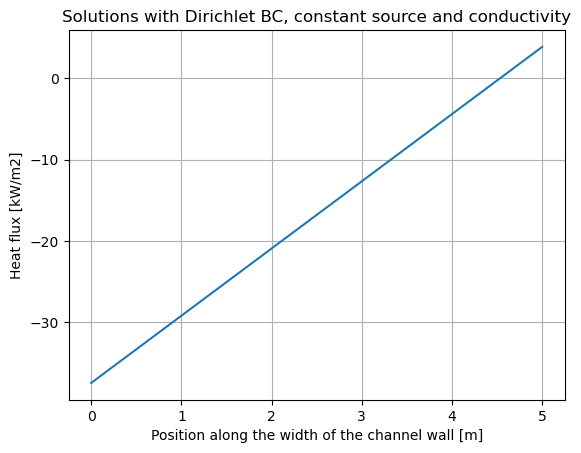

In [24]:
from pyfires import u_star_prime
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [25]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', (q_x(x_min) * n_x_a)/1000, 'W/m^2')
print('q_n(b) = ', (q_x(x_max) * n_x_b)/1000, 'W/m^2')

q_n(a) =  [37.4151] W/m^2
q_n(b) =  [3.8151] W/m^2


### [Results Comparison with Gold-Data](#toc)<a id = "Comparison"></a>

In [1]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/01-test-gold.txt')
u_gold = np.column_stack((x,u))

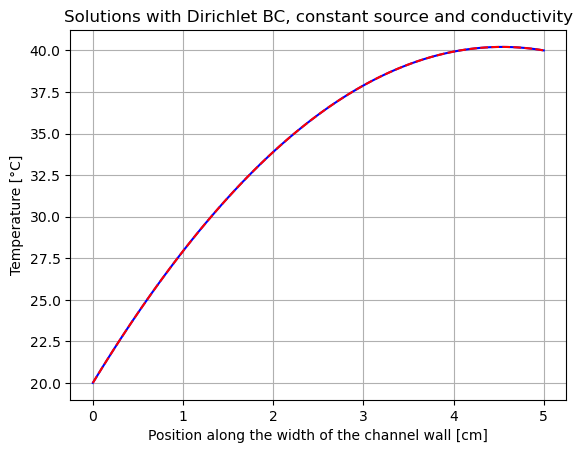

In [28]:
plot_func(lambda x: u_star(x, phi_list, lift_func, c_star_vec), x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]', gold_data=u_gold)

In [29]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/01-test-gold.txt')
u_gold_2 = np.column_stack((x,q))

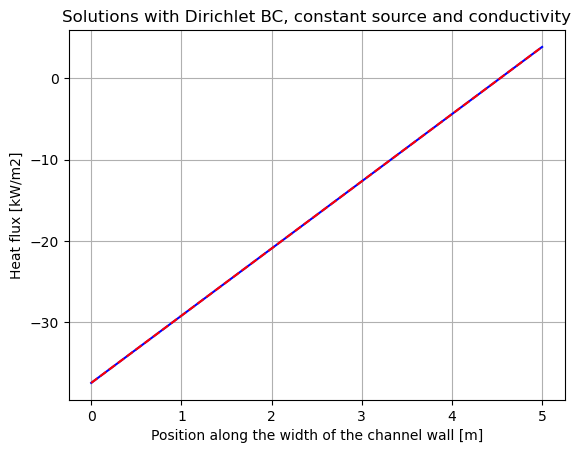

In [30]:
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime(x, phi_prime_list, lift_func_prime, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Dirichlet BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]', gold_data = u_gold_2)

### [Results Comparison with Analytical Solution](#toc)<a id = "Analytical"></a>

Attached for the time being is a copy of the analytical solution for this problem: (https://studentuml-my.sharepoint.com/:w:/r/personal/kyle_mills_student_uml_edu/Documents/Analytical%20Solution.docx?d=wc7e6aacabb7645a3b3c16f987223892c&csf=1&web=1&e=NecJEk) 

## [Conclusion](#toc)<a id = "Conclusion"></a>